In [56]:
"""
    Script to stream news articles and compare sentiment against cryptocurrency price
    Author: Ross MacWilliam
    Date: 01/02/2021
"""

import re
import csv
from time import sleep
import requests
import json
import pandas as pd
import numpy as np
import requests
import bs4
import psycopg2
from bs4 import BeautifulSoup
from datetime import datetime, timedelta, date

import pandas_datareader as pdr
import matplotlib.pyplot as plt

import shrimpy
import plotly.graph_objects as go
from newsapi import NewsApiClient
from yahoofinancials import YahooFinancials
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [57]:
class DatabaseClient:
    """
    Functionality for inserting and reading from the database
    """

    def __init__(self):
        # Connect to db
        self.con = psycopg2.connect(
            host='DESKTOP-VSKLGP8',
            database='postgres',
            user='postgres',
            password='postgres'
        )
        self.article_table = pd.DataFrame()

    def read_db(self):
        cur = self.con.cursor()

        cur.execute("SELECT  full_date, hour, trading_symbol, comp_sentiment FROM sentiment_dim"
                    " JOIN date_dim ON sentiment_dim.dateid = date_dim.dateid"
                    " JOIN time_dim ON sentiment_dim.timeid = time_dim.timeid;")

        rows = cur.fetchall()

        self.article_table = pd.DataFrame(data=rows, columns=['date', 'hour', 'clean_title', 'compound'])


        return self.article_table

    def insert_db(self, df):
        cur = self.con.cursor()

        for i in range(len(df)):
            cur.execute(f"SELECT dateid FROM date_dim WHERE full_date = '{df.dateid[i]}'")
            dateid = cur.fetchall()

            cur.execute(f"SELECT timeid FROM time_dim WHERE hour = '{df.timeid[i]}'")
            timeid = cur.fetchall()

            cur.execute(
                f"INSERT INTO sentiment_dim (dateid, timeid, trading_symbol, comp_sentiment) VALUES ({dateid[0][0]}, {timeid[0][0]}, '{df['trading_symbol'][i]}', {df['final_scores'][i]});")

        self.con.commit()

        self.con.close()


In [58]:
database_client = DatabaseClient()
df = database_client.read_db()

In [59]:
overall_headlines = df
overall_headlines['datetime'] = pd.to_datetime(df.date, infer_datetime_format=True) + df.hour.astype('timedelta64[h]')

overall_headlines.index =  pd.DatetimeIndex(overall_headlines['datetime'])
overall_headlines = overall_headlines.drop(['datetime'], axis=1)

# Remove duplicate columns
overall_headlines = overall_headlines[~overall_headlines.index.duplicated()]

overall_headlines = overall_headlines.asfreq('H')

In [61]:
overall_headlines['SMA'] = overall_headlines.compound.rolling(window=48,min_periods=1).mean()
overall_headlines['EWM'] = overall_headlines.compound.ewm(span=14).mean()
overall_headlines

,date,hour,clean_title,compound,SMA,EWM
datetime,,,,,,
2021-01-25 10:00:00,25/01/2021,10.0,BTC,0.9766,0.976600,0.976600
2021-01-25 11:00:00,NaN,NaN,NaN,NaN,0.976600,0.976600
2021-01-25 12:00:00,25/01/2021,12.0,BTC,0.9818,0.979200,0.979570
2021-01-25 13:00:00,25/01/2021,13.0,BTC,0.7717,0.910033,0.897004
2021-01-25 14:00:00,25/01/2021,14.0,BTC,-0.8126,0.479375,0.359721
...,...,...,...,...,...,...
2021-02-13 06:00:00,NaN,NaN,NaN,NaN,0.515020,0.576241
2021-02-13 07:00:00,NaN,NaN,NaN,NaN,0.515020,0.576241
2021-02-13 08:00:00,NaN,NaN,NaN,NaN,0.500466,0.576241


In [62]:
def get_latest_prices(trading_symbol):
    public_key = '12326758a39a720e15d064cab3c1f0a9332d107de453bd41926bb3acd565059e'
    secret_key = '6991cf4c9b518293429db0df6085d1731074bed8abccd7f0279a52fac5b0c1a8a2f6d28e11a50fbb1c6575d1407e637f9ad7c73fbddfa87c5d418fd58971f829'
    
    client = shrimpy.ShrimpyApiClient(public_key, secret_key)
        
    # get the candles for historical values
    candles = client.get_candles(
        'binance',  # exchange
        trading_symbol,      # base_trading_symbol
        'USDT',      # quote_trading_symbol
        '1h'       # interval
    )
        
    # Set the dataframe between these two dates
    tomorrows_date = (datetime.today() + timedelta(days=1)).strftime("%Y-%m-%d")
    starting_date = '2021-01-25'

    # Put pulled cryptocurrency values into a dataframe and set dates
    prices_df = pd.DataFrame(candles)
    prices_df['time'] = pd.to_datetime(prices_df['time'], infer_datetime_format=True).dt.tz_localize(None)

    latest_prices = prices_df[(prices_df['time'] > starting_date) & (prices_df['time'] <tomorrows_date)]
    latest_prices['close'] = latest_prices['close'].astype('float64')

    return latest_prices

In [63]:
prices_df = get_latest_prices('BTC')

<ipython-input-62-f82d79822a4f>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest_prices['close'] = latest_prices['close'].astype('float64')


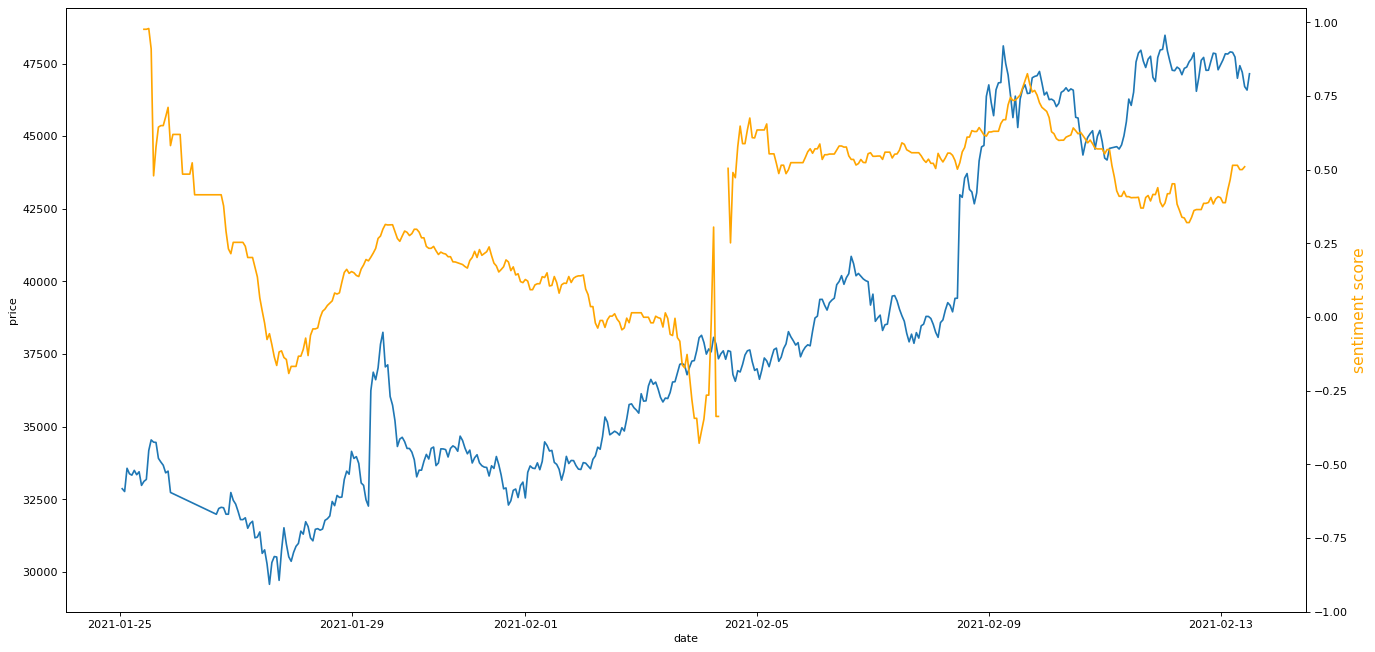

In [64]:
# create figure and axis objects with subplots()
fig,ax=plt.subplots(figsize=(20, 10),dpi=80)
ax.plot(prices_df['time'],prices_df['close'])
ax.set_xlabel("date")
ax.set_ylabel("price")
#ax.plot(prices_df['time'],prices_df['close'])
#plt.show()

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(overall_headlines.index,overall_headlines['SMA'],color="orange")
ax2.set_ylabel("sentiment score",color="orange",fontsize=14)
ax2.set_ylim(ymin=-1)
plt.show()

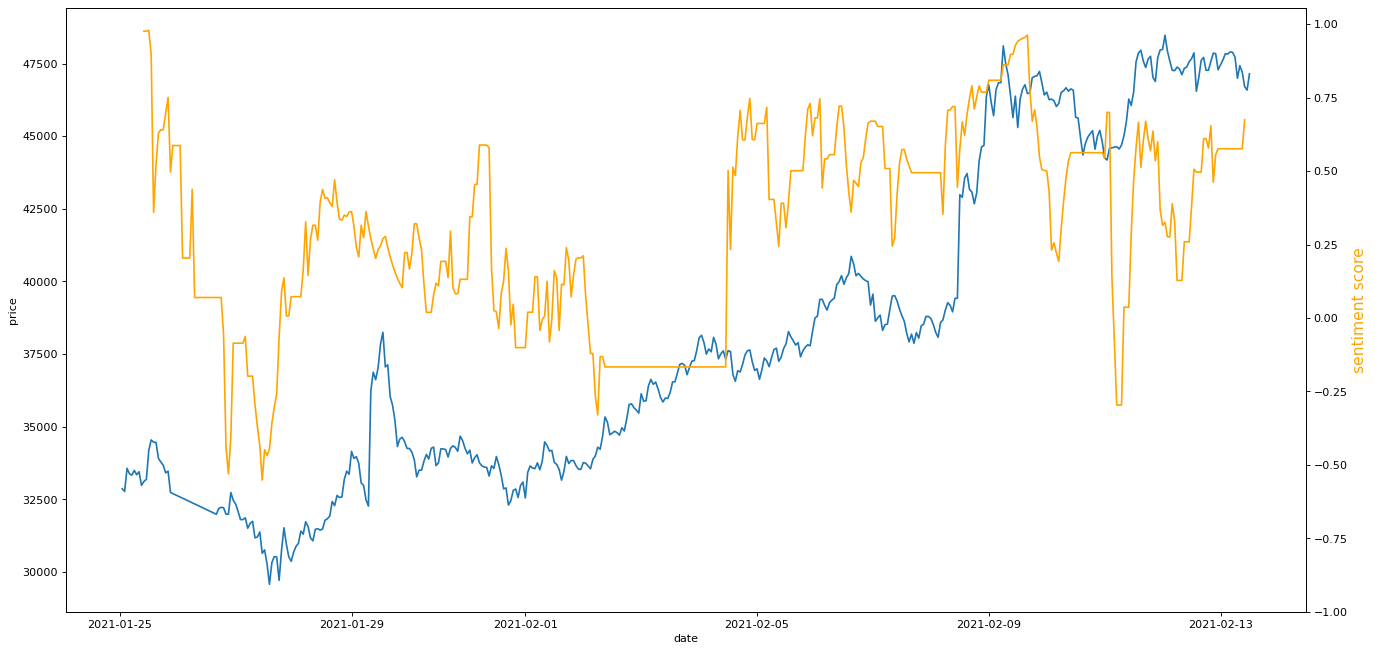

In [65]:
# create figure and axis objects with subplots()
fig,ax=plt.subplots(figsize=(20, 10),dpi=80)
ax.plot(prices_df['time'],prices_df['close'])
ax.set_xlabel("date")
ax.set_ylabel("price")
#ax.plot(prices_df['time'],prices_df['close'])
#plt.show()

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(overall_headlines.index,overall_headlines['EWM'],color="orange")
ax2.set_ylabel("sentiment score",color="orange",fontsize=14)
ax2.set_ylim(ymin=-1)
plt.show()

In [68]:
btc_price = prices_df
btc_price.index = pd.DatetimeIndex(btc_price['time'])
btc_price

,open,high,low,close,volume,quoteVolume,btcVolume,usdVolume,time
time,,,,,,,,,
2021-01-25 01:00:00,32575.1500000000000000,32908.9800000000000000,32411.7700000000000000,32864.98,2900.1470010000000000,9.467765e+07,2900.937152,9.467765e+07,2021-01-25 01:00:00
2021-01-25 02:00:00,32864.9700000000000000,32995.0000000000000000,32636.3600000000000000,32768.23,2347.9889800000000000,7.695855e+07,2348.112506,7.695855e+07,2021-01-25 02:00:00
2021-01-25 03:00:00,32768.2300000000000000,33674.4800000000000000,32580.3000000000000000,33568.18,4706.0363050000000000,1.561514e+08,4708.960408,1.561514e+08,2021-01-25 03:00:00
2021-01-25 04:00:00,33568.1700000000000000,33797.9600000000000000,33261.0000000000000000,33378.93,3754.0952800000000000,1.258166e+08,3753.077651,1.258166e+08,2021-01-25 04:00:00
2021-01-25 05:00:00,33378.0600000000000000,33461.5300000000000000,33188.0000000000000000,33331.13,2126.5775990000000000,7.089845e+07,2126.441169,7.089845e+07,2021-01-25 05:00:00
...,...,...,...,...,...,...,...,...,...
2021-02-13 08:00:00,46995.0100000000000000,47499.9300000000000000,46618.0000000000000000,47429.93,3749.6118880000000000,1.767790e+08,3750.199868,1.767790e+08,2021-02-13 08:00:00
2021-02-13 09:00:00,47429.9200000000000000,47569.0300000000000000,47061.0000000000000000,47205.53,2095.8424310000000000,9.920501e+07,2095.553517,9.920501e+07,2021-02-13 09:00:00
2021-02-13 10:00:00,47205.5200000000000000,47266.0500000000000000,46660.4400000000000000,46709.17,4954.5829900000000000,2.331211e+08,4953.807485,2.331211e+08,2021-02-13 10:00:00


In [69]:
overall_headlines

,date,hour,clean_title,compound,SMA,EWM
datetime,,,,,,
2021-01-25 10:00:00,25/01/2021,10.0,BTC,0.9766,0.976600,0.976600
2021-01-25 11:00:00,NaN,NaN,NaN,NaN,0.976600,0.976600
2021-01-25 12:00:00,25/01/2021,12.0,BTC,0.9818,0.979200,0.979570
2021-01-25 13:00:00,25/01/2021,13.0,BTC,0.7717,0.910033,0.897004
2021-01-25 14:00:00,25/01/2021,14.0,BTC,-0.8126,0.479375,0.359721
...,...,...,...,...,...,...
2021-02-13 06:00:00,NaN,NaN,NaN,NaN,0.515020,0.576241
2021-02-13 07:00:00,NaN,NaN,NaN,NaN,0.515020,0.576241
2021-02-13 08:00:00,NaN,NaN,NaN,NaN,0.500466,0.576241


In [74]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

In [77]:
# Importing Training Set
dataset_train = btc_price
# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:6]

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['time'])

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (448, 9)
All timestamps == 448
Featured selected: ['high', 'low', 'close', 'volume', 'quoteVolume']


In [79]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.to_numpy()

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (448, 5).


array([[3.29089800e+04, 3.24117700e+04, 3.28649800e+04, 2.90014700e+03,
        9.46776528e+07],
       [3.29950000e+04, 3.26363600e+04, 3.27682300e+04, 2.34798898e+03,
        7.69585469e+07],
       [3.36744800e+04, 3.25803000e+04, 3.35681800e+04, 4.70603630e+03,
        1.56151422e+08],
       ...,
       [4.72660500e+04, 4.66604400e+04, 4.67091700e+04, 4.95458299e+03,
        2.33121109e+08],
       [4.69900000e+04, 4.62510000e+04, 4.65892000e+04, 5.39986052e+03,
        2.51729345e+08],
       [4.71912600e+04, 4.62025300e+04, 4.71518900e+04, 2.38817129e+03,
        1.11783844e+08]])

In [80]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])


array([[-1.01927835e+00],
       [-1.00366183e+00],
       [-8.80305527e-01],
       [-8.57888331e-01],
       [-9.18965569e-01],
       [-9.02904268e-01],
       [-9.00718465e-01],
       [-9.12366402e-01],
       [-9.03267359e-01],
       [-9.72617610e-01],
       [-9.42014542e-01],
       [-7.66745398e-01],
       [-6.95229314e-01],
       [-6.62356931e-01],
       [-7.14300633e-01],
       [-7.12281850e-01],
       [-7.76429017e-01],
       [-8.15479381e-01],
       [-8.59627533e-01],
       [-9.16716224e-01],
       [-9.18479028e-01],
       [-1.16735747e+00],
       [-1.14163615e+00],
       [-1.12075846e+00],
       [-1.11097681e+00],
       [-1.11258893e+00],
       [-1.12579997e+00],
       [-1.05107961e+00],
       [-1.01693641e+00],
       [-1.08312596e+00],
       [-1.10118971e+00],
       [-1.13645122e+00],
       [-1.19942924e+00],
       [-1.17880208e+00],
       [-1.19905707e+00],
       [-1.23422419e+00],
       [-1.20423474e+00],
       [-1.22981627e+00],
       [-1.3

In [81]:
X_train = []
y_train = []

n_future = 60   # Number of days we want top predict into the future
n_past = 90     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (299, 90, 4).
y_train shape == (299, 1).


In [82]:

# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

In [83]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')


In [84]:

%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
1/1 [==============================] - 6s 6s/step - loss: 0.9085 - val_loss: 1.6464

Epoch 00001: val_loss improved from inf to 1.64642, saving model to weights.h5
Epoch 2/30
1/1 [==============================] - 1s 632ms/step - loss: 0.4697 - val_loss: 0.8937

Epoch 00002: val_loss improved from 1.64642 to 0.89370, saving model to weights.h5
Epoch 3/30
1/1 [==============================] - 0s 157ms/step - loss: 0.3102 - val_loss: 0.3631

Epoch 00003: val_loss improved from 0.89370 to 0.36310, saving model to weights.h5
Epoch 4/30
1/1 [==============================] - 0s 171ms/step - loss: 0.1793 - val_loss: 0.0864

Epoch 00004: val_loss improved from 0.36310 to 0.08642, saving model to weights.h5
Epoch 5/30
1/1 [==============================] - 0s 157ms/step - loss: 0.1758 - val_loss: 0.0970

Epoch 00005: val_loss did not improve from 0.08642
Epoch 6/30
1/1 [==============================] - 0s 168ms/step - loss: 0.1522 - val_loss: 0.0554

Epoch 00006: val_loss improved

In [88]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='H').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [89]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

In [95]:
y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Open']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Open']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series()

PREDICTION_TRAIN.head(10)

,Open
2021-02-04 18:00:00,37010.207031
2021-02-04 19:00:00,37047.683594
2021-02-04 20:00:00,37118.226562
2021-02-04 21:00:00,37274.996094
2021-02-04 22:00:00,37438.417969
2021-02-04 23:00:00,37587.613281
2021-02-05 00:00:00,37670.011719
2021-02-05 01:00:00,37701.609375
2021-02-05 02:00:00,37686.144531
2021-02-05 03:00:00,37650.703125


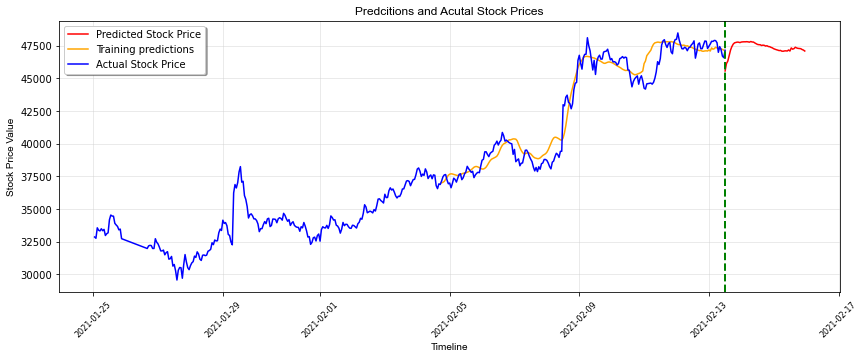

In [102]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2012-06-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Open'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['close'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

In [101]:
dataset_train

,high,low,close,volume,quoteVolume
time,,,,,
2021-01-25 01:00:00,32908.98,32411.77,32864.98,2900.147001,9.467765e+07
2021-01-25 02:00:00,32995.00,32636.36,32768.23,2347.988980,7.695855e+07
2021-01-25 03:00:00,33674.48,32580.30,33568.18,4706.036305,1.561514e+08
2021-01-25 04:00:00,33797.96,33261.00,33378.93,3754.095280,1.258166e+08
2021-01-25 05:00:00,33461.53,33188.00,33331.13,2126.577599,7.089845e+07
...,...,...,...,...,...
2021-02-13 08:00:00,47499.93,46618.00,47429.93,3749.611888,1.767790e+08
2021-02-13 09:00:00,47569.03,47061.00,47205.53,2095.842431,9.920501e+07
2021-02-13 10:00:00,47266.05,46660.44,46709.17,4954.582990,2.331211e+08
